In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/company-bankruptcy-prediction/data.csv


In [23]:
from keras.layers import Dropout, BatchNormalization
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
import itertools
from keras.optimizers import RMSprop,Adam, SGD
import tensorflow as tf
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn import metrics   
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

In [5]:
# Stole this function from Google to plot neural nets!! It'll be useful later

In [6]:
import matplotlib.pyplot as plt

def draw_neural_net(ax, left, right, bottom, top, layer_sizes):
    '''
    Draw a neural network cartoon using matplotilb.
    
    :usage:
        >>> fig = plt.figure(figsize=(12, 12))
        >>> draw_neural_net(fig.gca(), .1, .9, .1, .9, [4, 7, 2])
    
    :parameters:
        - ax : matplotlib.axes.AxesSubplot
            The axes on which to plot the cartoon (get e.g. by plt.gca())
        - left : float
            The center of the leftmost node(s) will be placed here
        - right : float
            The center of the rightmost node(s) will be placed here
        - bottom : float
            The center of the bottommost node(s) will be placed here
        - top : float
            The center of the topmost node(s) will be placed here
        - layer_sizes : list of int
            List of layer sizes, including input and output dimensionality
    '''
    n_layers = len(layer_sizes)
    v_spacing = (top - bottom)/float(max(layer_sizes))
    h_spacing = (right - left)/float(len(layer_sizes) - 1)
    # Nodes
    for n, layer_size in enumerate(layer_sizes):
        layer_top = v_spacing*(layer_size - 1)/2. + (top + bottom)/2.
        for m in range(layer_size):
            circle = plt.Circle((n*h_spacing + left, layer_top - m*v_spacing), v_spacing/4.,
                                color='w', ec='k', zorder=4)
            ax.add_artist(circle)
    # Edges
    for n, (layer_size_a, layer_size_b) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
        layer_top_a = v_spacing*(layer_size_a - 1)/2. + (top + bottom)/2.
        layer_top_b = v_spacing*(layer_size_b - 1)/2. + (top + bottom)/2.
        for m in range(layer_size_a):
            for o in range(layer_size_b):
                line = plt.Line2D([n*h_spacing + left, (n + 1)*h_spacing + left],
                                  [layer_top_a - m*v_spacing, layer_top_b - o*v_spacing], c='k')
                ax.add_artist(line)

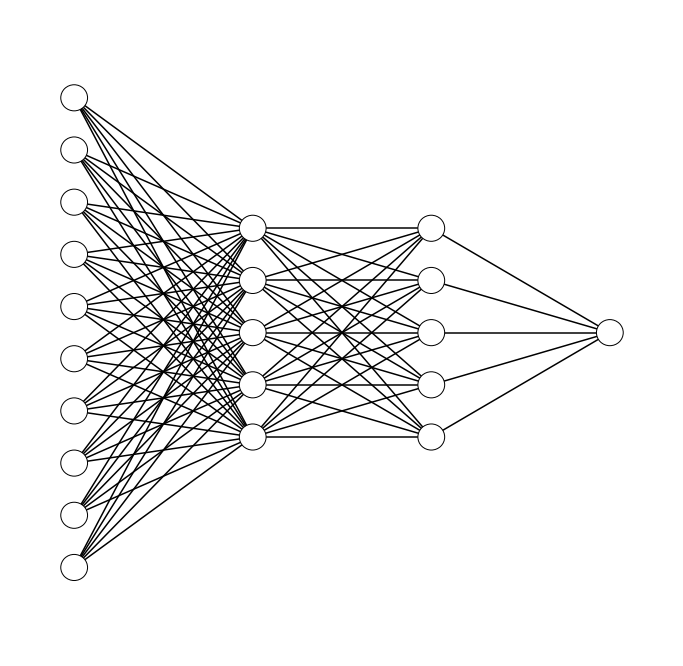

In [12]:
fig = plt.figure(figsize=(12, 12))
ax = fig.gca()
ax.axis('off')
draw_neural_net(ax, .1, .9, .1, .9, [10, 5, 5, 1])

In [40]:
df = pd.read_csv('../input/company-bankruptcy-prediction/data.csv')

In [14]:
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 96 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   Bankrupt?                                                 6819 non-null   int64  
 1    ROA(C) before interest and depreciation before interest  6819 non-null   float64
 2    ROA(A) before interest and % after tax                   6819 non-null   float64
 3    ROA(B) before interest and depreciation after tax        6819 non-null   float64
 4    Operating Gross Margin                                   6819 non-null   float64
 5    Realized Sales Gross Margin                              6819 non-null   float64
 6    Operating Profit Rate                                    6819 non-null   float64
 7    Pre-tax net Interest Rate                                6819 non-null   float64
 8    After-tax net Int

Bankrupt?                                                   0
 ROA(C) before interest and depreciation before interest    0
 ROA(A) before interest and % after tax                     0
 ROA(B) before interest and depreciation after tax          0
 Operating Gross Margin                                     0
                                                           ..
 Liability to Equity                                        0
 Degree of Financial Leverage (DFL)                         0
 Interest Coverage Ratio (Interest expense to EBIT)         0
 Net Income Flag                                            0
 Equity to Liability                                        0
Length: 96, dtype: int64

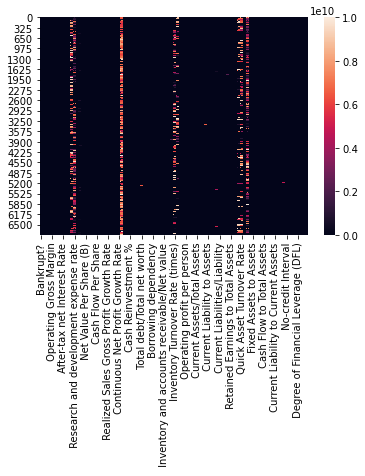

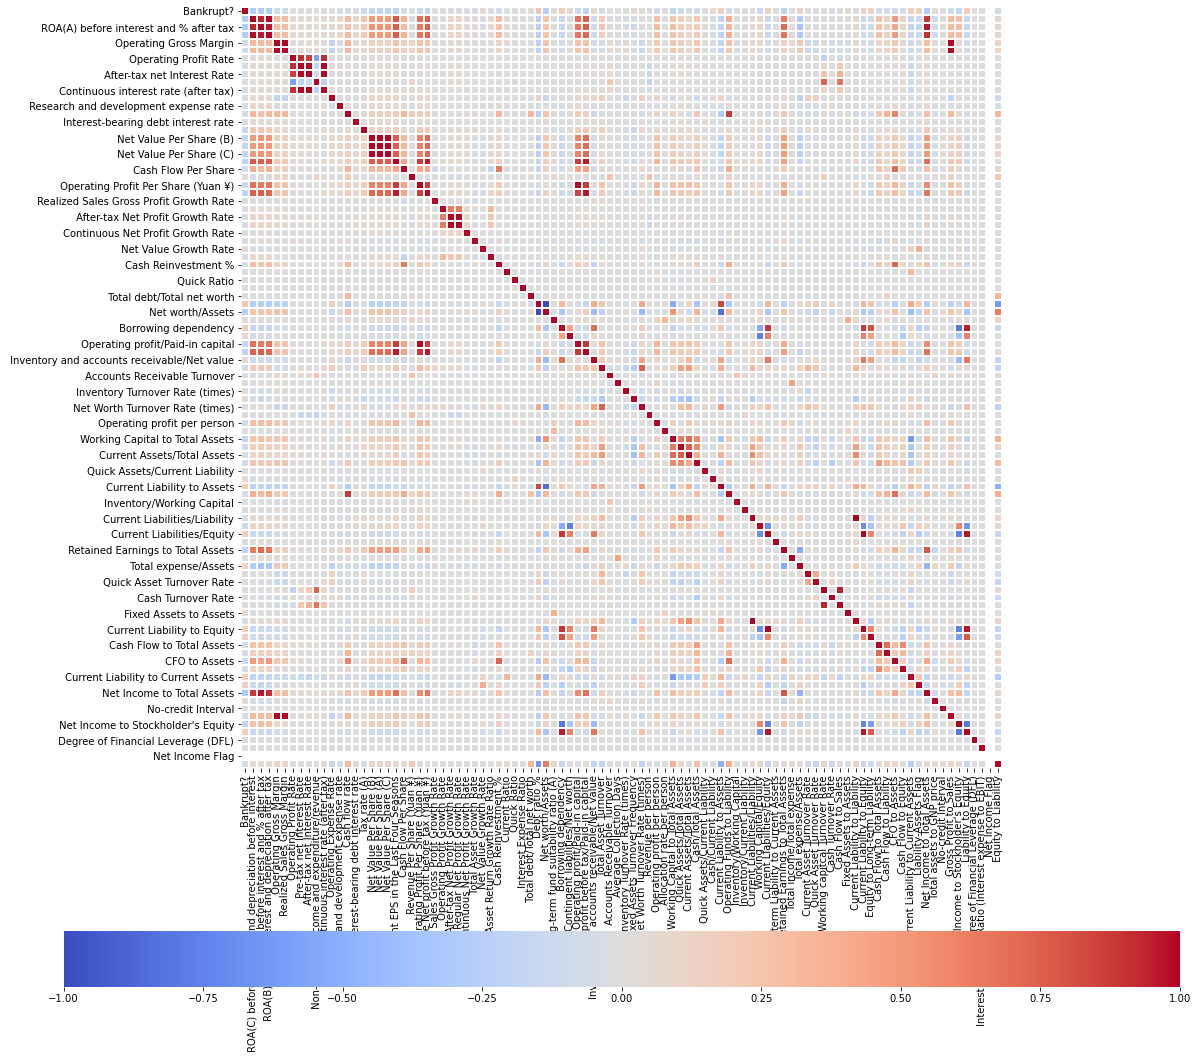

In [15]:
sns.heatmap(df)
plt.show()
fig, ax = plt.subplots(figsize=(20,20))
plx = sns.heatmap(df.corr(), annot=False, linewidths=1, ax=ax, fmt='.1g', cmap='coolwarm', vmin=-1, vmax=1,cbar_kws= {'orientation': 'horizontal'}, square=True) 

In [16]:
df.head()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474
3,1,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,...,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,1,0.023982
4,1,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,...,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,1,0.035490


In [41]:
Y = df['Bankrupt?']
X = df.drop(['Bankrupt?'], axis=1)

In [42]:
X_train, X_val_and_test, Y_train, Y_val_and_test = train_test_split(X, Y, test_size=0.3, random_state = 42)
X_val, X_test, Y_val, Y_test = train_test_split(X_val_and_test, Y_val_and_test, test_size=0.5, random_state = 42)

In [19]:
print(X_train.shape, X_val.shape, X_test.shape, Y_train.shape, Y_val.shape, Y_test.shape)

(4773, 95) (1023, 95) (1023, 95) (4773,) (1023,) (1023,)


In [43]:
model = Sequential()

model.add(Dense(64, activation='relu', input_shape=(95,))) # I saw online the hidden layers should be = InputSize*(2/3)+OutputSize. Lets see how it works out!
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(64, activation='relu')) 
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(1, activation='sigmoid'))

In [44]:
# Saving the model
checkpoint = ModelCheckpoint('BankruptcyModel.h5',
                             monitor='val_loss',
                             mode='min',
                             save_best_only=True,
                             verbose=1)
# Stopping at a certain number of epochs to save time if model isn't learning
# This one may only be good for restoring model
earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=25,
                          verbose=1,
                          restore_best_weights=True
                          )
# Reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=3,
                              verbose=1,
                              min_delta=0.0001)

callbacks = [earlystop,checkpoint,reduce_lr]

opt = keras.optimizers.Adam(lr=0.001)

# Now put it all together
model.compile(loss='binary_crossentropy',
              optimizer = opt,
              metrics=['accuracy'])

In [52]:
hist = model.fit(X_train, Y_train,
        epochs=25,
        validation_data=(X_val, Y_val),
        callbacks = callbacks)

Epoch 1/25
150/150 [==============================] - 1s 3ms/step - loss: 0.1202 - accuracy: 0.9696 - val_loss: 0.1554 - val_accuracy: 0.9619

Epoch 00001: val_loss did not improve from 0.15464
Epoch 2/25
150/150 [==============================] - 0s 3ms/step - loss: 0.1191 - accuracy: 0.9709 - val_loss: 0.1555 - val_accuracy: 0.9619

Epoch 00002: val_loss did not improve from 0.15464
Epoch 3/25
150/150 [==============================] - 0s 3ms/step - loss: 0.1215 - accuracy: 0.9713 - val_loss: 0.1556 - val_accuracy: 0.9619

Epoch 00003: val_loss did not improve from 0.15464
Epoch 4/25
150/150 [==============================] - 0s 3ms/step - loss: 0.1246 - accuracy: 0.9700 - val_loss: 0.1558 - val_accuracy: 0.9619

Epoch 00004: val_loss did not improve from 0.15464

Epoch 00004: ReduceLROnPlateau reducing learning rate to 3.3554436145371517e-21.
Epoch 5/25
150/150 [==============================] - 0s 3ms/step - loss: 0.1262 - accuracy: 0.9698 - val_loss: 0.1557 - val_accuracy: 0.9619


In [71]:
model.evaluate(X_test, Y_test)[1]

32/32 [==============================] - 0s 1ms/step - loss: 0.1518 - accuracy: 0.9629


0.9628543257713318

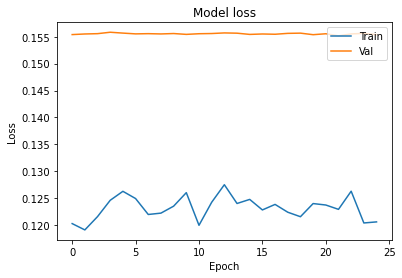

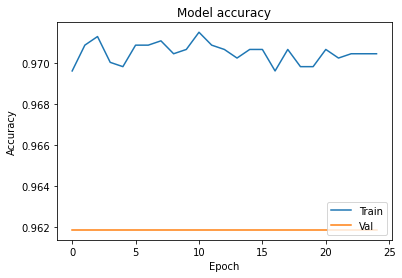

In [55]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()

In [56]:
# Seem's like all my progress is made in epoch 1. May point to simplier NN or useage of RF / XGB..

In [ ]:
# 96.28% Still isn't bad at all! Lets make it simple.

In [57]:
model2 = Sequential()

model2.add(Dense(64, activation='relu', input_shape=(95,))) # I saw online the hidden layers should be = InputSize*(2/3)+OutputSize. Lets see how it works out!
model2.add(BatchNormalization())
model2.add(Dropout(0.25))

model2.add(Dense(1, activation='sigmoid'))

# Saving the model
checkpoint2 = ModelCheckpoint('BankruptcyModel2.h5',
                             monitor='val_loss',
                             mode='min',
                             save_best_only=True,
                             verbose=1)
# Stopping at a certain number of epochs to save time if model isn't learning
# This one may only be good for restoring model
earlystop2 = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=25,
                          verbose=1,
                          restore_best_weights=True
                          )
# Reduce learning rate
reduce_lr2 = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=3,
                              verbose=1,
                              min_delta=0.0001)

callbacks2 = [earlystop2,checkpoint2,reduce_lr2]

opt2 = keras.optimizers.Adam(lr=0.001)

# Now put it all together
model2.compile(loss='binary_crossentropy',
              optimizer = opt2,
              metrics=['accuracy'])

In [58]:
model2.fit(X_train, Y_train,
        epochs=25,
        validation_data=(X_val, Y_val),
        callbacks = callbacks)
# I wont bother plotting with history since it'll remain the same.

Epoch 1/25
150/150 [==============================] - 1s 4ms/step - loss: 0.6725 - accuracy: 0.6547 - val_loss: 0.3268 - val_accuracy: 0.9335

Epoch 00001: val_loss did not improve from 0.15464
Epoch 2/25
150/150 [==============================] - 0s 2ms/step - loss: 0.2723 - accuracy: 0.9379 - val_loss: 0.1924 - val_accuracy: 0.9521

Epoch 00002: val_loss did not improve from 0.15464
Epoch 3/25
150/150 [==============================] - 0s 2ms/step - loss: 0.1633 - accuracy: 0.9650 - val_loss: 0.1763 - val_accuracy: 0.9560

Epoch 00003: val_loss did not improve from 0.15464
Epoch 4/25
150/150 [==============================] - 0s 2ms/step - loss: 0.1706 - accuracy: 0.9618 - val_loss: 0.1770 - val_accuracy: 0.9560

Epoch 00004: val_loss did not improve from 0.15464
Epoch 5/25
150/150 [==============================] - 0s 3ms/step - loss: 0.1376 - accuracy: 0.9707 - val_loss: 0.1744 - val_accuracy: 0.9560

Epoch 00005: val_loss did not improve from 0.15464
Epoch 6/25
150/150 [==========

In [66]:
model2.evaluate(X_test, Y_test)[1]

32/32 [==============================] - 0s 1ms/step - loss: 0.1553 - accuracy: 0.9619


0.9618768095970154

In [67]:
# Just a bit worse, so this time I'll up it

In [68]:
model3 = Sequential()

model3.add(Dense(64, activation='relu', input_shape=(95,)))
model3.add(BatchNormalization())
model3.add(Dropout(0.25))

model3.add(Dense(64, activation='relu'))
model3.add(BatchNormalization())
model3.add(Dropout(0.25))

model3.add(Dense(64, activation='relu'))
model3.add(BatchNormalization())
model3.add(Dropout(0.25))

model3.add(Dense(64, activation='relu'))
model3.add(BatchNormalization())
model3.add(Dropout(0.25))

model3.add(Dense(1, activation='sigmoid'))

# Saving the model
checkpoint3 = ModelCheckpoint('BankruptcyModel3.h5',
                             monitor='val_loss',
                             mode='min',
                             save_best_only=True,
                             verbose=1)
# Stopping at a certain number of epochs to save time if model isn't learning
# This one may only be good for restoring model
earlystop3 = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=25,
                          verbose=1,
                          restore_best_weights=True
                          )
# Reduce learning rate
reduce_lr3 = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=3,
                              verbose=1,
                              min_delta=0.0001)

callbacks2 = [earlystop3,checkpoint3,reduce_lr3]

opt3 = keras.optimizers.Adam(lr=0.001)

# Now put it all together
model3.compile(loss='binary_crossentropy',
              optimizer = opt3,
              metrics=['accuracy'])

In [69]:
model3.fit(X_train, Y_train,
        epochs=25,
        validation_data=(X_val, Y_val),
        callbacks = callbacks)

Epoch 1/25
150/150 [==============================] - 2s 6ms/step - loss: 0.7148 - accuracy: 0.6155 - val_loss: 0.2830 - val_accuracy: 0.9619

Epoch 00001: val_loss did not improve from 0.15464
Epoch 2/25
150/150 [==============================] - 1s 4ms/step - loss: 0.2921 - accuracy: 0.9300 - val_loss: 0.1781 - val_accuracy: 0.9619

Epoch 00002: val_loss did not improve from 0.15464
Epoch 3/25
150/150 [==============================] - 1s 4ms/step - loss: 0.1977 - accuracy: 0.9584 - val_loss: 0.1612 - val_accuracy: 0.9619

Epoch 00003: val_loss did not improve from 0.15464
Epoch 4/25
150/150 [==============================] - 1s 4ms/step - loss: 0.1627 - accuracy: 0.9644 - val_loss: 0.1584 - val_accuracy: 0.9619

Epoch 00004: val_loss did not improve from 0.15464
Epoch 5/25
150/150 [==============================] - 1s 4ms/step - loss: 0.1517 - accuracy: 0.9679 - val_loss: 0.1644 - val_accuracy: 0.9619

Epoch 00005: val_loss did not improve from 0.15464
Epoch 6/25
150/150 [==========

In [70]:
model3.evaluate(X_test, Y_test)[1]

32/32 [==============================] - 0s 1ms/step - loss: 0.1531 - accuracy: 0.9619


0.9618768095970154

In [72]:
# Same as last time, gonna try XBG & RF Before messing with the first NN anymore

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state = 42)

In [94]:
rf = RandomForestClassifier(n_estimators = 90)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

In [96]:
print("RandomForest acc: ", metrics.accuracy_score(y_test, y_pred))

RandomForest acc:  0.9643206256109482


In [99]:
XG = xgb.XGBClassifier() 
XG.fit(X_train, y_train)
y_pred = XG.predict(X_test)

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:37:31] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [100]:
print('XGBoost acc: ', metrics.accuracy_score(y_test, y_pred))

XGBoost acc:  0.9613880742913001


In [103]:
from sklearn.model_selection import cross_val_score
XGAvgAcc = print(cross_val_score(XG, X_test, y_test, cv=10, scoring='accuracy').mean())
RFAvgAcc = print(cross_val_score(rf, X_test, y_test, cv=10, scoring='accuracy').mean())

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:40:35] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:40:36] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:40:37] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:40:37] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:40:38] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:40:39] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:40:39] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:40:40] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:40:41] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:40:42] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.9613821138211381
0.9633428981348636


In [106]:
# Looks like Random Forest won out with an overall acc of 96.33% which is only .05 points from our other model. Wonder if a change to SGD will do anything.

In [112]:
# Need to get this back rq
X_train, X_val_and_test, Y_train, Y_val_and_test = train_test_split(X, Y, test_size=0.3, random_state = 42)
X_val, X_test, Y_val, Y_test = train_test_split(X_val_and_test, Y_val_and_test, test_size=0.5, random_state = 42)

In [117]:
model1 = Sequential()

model1.add(Dense(64, activation='relu', input_shape=(95,)))
model1.add(BatchNormalization())
model1.add(Dropout(0.25))

model1.add(Dense(64, activation='relu')) 
model1.add(BatchNormalization())
model1.add(Dropout(0.25))

model1.add(Dense(1, activation='sigmoid'))


# Saving the model
checkpoint1 = ModelCheckpoint('BankruptcyModel1.h5',
                             monitor='val_loss',
                             mode='min',
                             save_best_only=True,
                             verbose=1)
# Stopping at a certain number of epochs to save time if model isn't learning
# This one may only be good for restoring model
earlystop1 = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=25,
                          verbose=1,
                          restore_best_weights=True
                          )
# Reduce learning rate
reduce_lr1 = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=3,
                              verbose=1,
                              min_delta=0.0001)

callbacks1 = [earlystop1,checkpoint1,reduce_lr1]

opt1 = keras.optimizers.RMSprop(lr=0.001)

# Now put it all together
model1.compile(loss='binary_crossentropy',
              optimizer = opt1,
              metrics=['accuracy'])

In [118]:
hist1 = model1.fit(X_train, Y_train,
        epochs=25,
        validation_data=(X_val, Y_val),
        callbacks = callbacks)

Epoch 1/25
150/150 [==============================] - 2s 4ms/step - loss: 0.6662 - accuracy: 0.6454 - val_loss: 0.2242 - val_accuracy: 0.9619

Epoch 00001: val_loss did not improve from 0.18940
Epoch 2/25
150/150 [==============================] - 0s 3ms/step - loss: 0.2256 - accuracy: 0.9527 - val_loss: 0.1614 - val_accuracy: 0.9619

Epoch 00002: val_loss improved from 0.18940 to 0.16138, saving model to BankruptcyModel.h5
Epoch 3/25
150/150 [==============================] - 0s 3ms/step - loss: 0.1415 - accuracy: 0.9703 - val_loss: 0.1584 - val_accuracy: 0.9619

Epoch 00003: val_loss improved from 0.16138 to 0.15840, saving model to BankruptcyModel.h5
Epoch 4/25
150/150 [==============================] - 0s 3ms/step - loss: 0.1367 - accuracy: 0.9708 - val_loss: 0.1619 - val_accuracy: 0.9619

Epoch 00004: val_loss did not improve from 0.15840
Epoch 5/25
150/150 [==============================] - 0s 3ms/step - loss: 0.1282 - accuracy: 0.9722 - val_loss: 0.1644 - val_accuracy: 0.9619

E

In [119]:
model1.evaluate(X_test, Y_test)[1]

32/32 [==============================] - 0s 1ms/step - loss: 0.1552 - accuracy: 0.9619


0.9618768095970154

In [ ]:
# Adam opt wins, now fix up the model

In [212]:
X.astype('float32')
Y.astype('float32')
X_train, X_val_and_test, Y_train, Y_val_and_test = train_test_split(X, Y, test_size=0.3, random_state = 42)
X_val, X_test, Y_val, Y_test = train_test_split(X_val_and_test, Y_val_and_test, test_size=0.5, random_state = 42)

In [165]:
model = Sequential()

model.add(Dense(64, activation='relu', input_shape=(95,))) # I saw online the hidden layers should be = InputSize*(2/3)+OutputSize. Lets see how it works out!
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(32, activation='relu')) 
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(1, activation='sigmoid'))

# Saving the model
checkpoint = ModelCheckpoint('BankruptcyModel.h5',
                             monitor='val_loss',
                             mode='min',
                             save_best_only=True,
                             verbose=1)
# Stopping at a certain number of epochs to save time if model isn't learning
# This one may only be good for restoring model
earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=25,
                          verbose=1,
                          restore_best_weights=True
                          )
# Reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=3,
                              verbose=1,
                              min_delta=0.0001)

callbacks = [earlystop,checkpoint,reduce_lr]

opt = keras.optimizers.Adam(lr=0.001)

# Now put it all together
model.compile(loss='binary_crossentropy',
              optimizer = opt,
              metrics=['accuracy'])

In [166]:
hist = model.fit(X_train, Y_train,
        epochs=25,
        validation_data=(X_val, Y_val),
        callbacks = callbacks)

Epoch 1/25
150/150 [==============================] - 2s 5ms/step - loss: 0.7487 - accuracy: 0.5894 - val_loss: 0.3176 - val_accuracy: 0.9541

Epoch 00001: val_loss improved from inf to 0.31760, saving model to BankruptcyModel.h5
Epoch 2/25
150/150 [==============================] - 0s 3ms/step - loss: 0.3656 - accuracy: 0.8889 - val_loss: 0.1894 - val_accuracy: 0.9619

Epoch 00002: val_loss improved from 0.31760 to 0.18939, saving model to BankruptcyModel.h5
Epoch 3/25
150/150 [==============================] - 0s 3ms/step - loss: 0.2009 - accuracy: 0.9597 - val_loss: 0.1589 - val_accuracy: 0.9619

Epoch 00003: val_loss improved from 0.18939 to 0.15889, saving model to BankruptcyModel.h5
Epoch 4/25
150/150 [==============================] - 0s 3ms/step - loss: 0.1646 - accuracy: 0.9630 - val_loss: 0.1588 - val_accuracy: 0.9619

Epoch 00004: val_loss improved from 0.15889 to 0.15882, saving model to BankruptcyModel.h5
Epoch 5/25
150/150 [==============================] - 0s 3ms/step - 

In [ ]:
# The score to beat is .962854

In [168]:
model = model.evaluate(X_test, Y_test)[1]
if model >= 0.9628543257713318:
    if model == 0.9628543257713318:
        print('No change in acc')
    if model > 0.9628543257713318:
        print('Better model')
        print(model)
else:
    print('Worse acc')
    model

32/32 [==============================] - 0s 1ms/step - loss: 0.1567 - accuracy: 0.9629
No change in acc


In [ ]:
# Seems like our first model got the best accuracy of 96.28%
# BUT Our overall best model was XGBoost with an acc of 96.33%